## Machine Learning Project: Japanese Vowel speaker classification

### Importing data into time series arrays 

In [1]:
import numpy as np
import copy

In [2]:
# importing data sets
trainData = np.loadtxt("ae.train")
testData = np.loadtxt("ae.test")

In [3]:
# obtaining 270 training time series arrays
# arrays are (N x 12); where N is length of time series recording and 12 is number of dimensions (ie channels)
trainInputs = np.empty((270,1), dtype=object)
readindex = 0

for i in range(1,271):
    readindex = readindex + 1  
    l = 0
    while trainData[readindex-1, 1] != 1:
        l = l + 1 
        readindex = readindex + 1
    trainInputs[i-1,0] = trainData[readindex-l-1:readindex-1,:]


# obtaining 370 test time series arrays 
# arrays are (N x 12); where N is length of time series recording and 12 is number of dimensions (ie channels)
testInputs = np.empty((370,1), dtype=object)
readindex = 0

for i in range(1,371):
    readindex = readindex + 1
    l = 0 
    while testData[readindex-1, 1] != 1:
        l = l+1 
        readindex = readindex + 1
    testInputs[i-1,0] = testData[readindex-l-1:readindex-1,:] 

In [4]:
# obtaining 270 training outputs (speaker targets)
# arrays are (N x 9); where N is length of time series recording and 9 is number of different speakers
# the speaker is indicated with a '1'
trainOutputs = np.empty((270,1), dtype=object)

for i in range(1,271):
    l = np.size(trainInputs[i-1,0],0)
    teacher = np.zeros((l,9))
    speakerIndex = np.ceil(i/30)
    teacher[:,np.int(speakerIndex)-1] = 1 
    trainOutputs[i-1,0] = teacher

# obtaining 370 test outputs (speaker targets)
# arrays are (N x 9); where N is length of time series recording and 9 is number of different speakers
# the speaker is indicated with a '1'
testOutputs = np.empty((370,1), dtype=object)
speakerIndex = 1
blockCounter = 0
blockLengthes = [31, 35, 88, 44, 29, 24, 40, 50, 29]
for i in range(1, 371):
    blockCounter = blockCounter + 1 
    if blockCounter == blockLengthes[speakerIndex-1] + 1:
        speakerIndex = speakerIndex + 1
        blockCounter = 1
    l = np.size(testInputs[i-1,0], 0)
    teacher = np.zeros((l,9))
    teacher[:,np.int(speakerIndex)-1] = 1   
    testOutputs[i-1, 0] = teacher

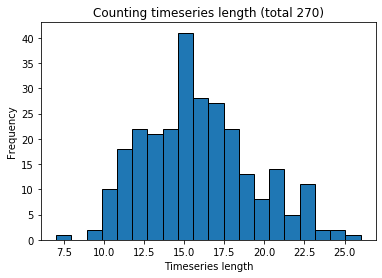

In [5]:
# Prints histogram of timeseries length (exploratory analysis)
import matplotlib.pyplot as plt

histos = np.zeros(270)

for i in range(270):
    histos[i] = (len(trainInputs[i, 0]))

#print(histos)
plt.title('Counting timeseries length (total 270)')
plt.xlabel('Timeseries length')
plt.ylabel('Frequency')
plt.hist(histos, bins = 20, ec='black')
plt.show()

In [6]:
# Pads the training inputs with zeroes to make all the timeseries of equal length
size_max = 12 * 26
trainInputsPadded = np.empty((270,size_max), dtype=object)
trainInputsPaddedBefore = np.empty((270,size_max), dtype=object)

idx = 0 
for element in trainInputs:
    #print(element)
    #print("----")
    element = np.ndarray.flatten(element[0])
    # print(element)
    # print(len(element))
    # Pads zeroes before    
    elements = element
    elements = np.pad(elements, (size_max - len(elements), 0), 'constant')
    trainInputsPaddedBefore[idx] = elements
    
    # Pads zeroes after
    # Pad element with zeroes until it reaches the shape of the largest timeseries (12 * 26 = 312)
    shape = np.shape(element)
    padded_array = np.zeros(size_max)
    padded_array[:shape[0]] = element  
    element = padded_array
    # print(element)

    trainInputsPadded[idx] = element
    idx = idx + 1

trainOutputsNew = np.empty((270,1), dtype=object)

# Transforms the trainOutputs in classes 1-9
idxx = 0
for elements in trainOutputs:
    for i in range(len(elements[0][0])):
       if elements[0][0][i] == 1:
           trainOutputsNew[idxx] = i + 1
           idxx = idxx + 1
        
trainOutputsNew = np.ravel(trainOutputsNew)
trainOutputsNew = trainOutputsNew.astype('int')

# print('trainInputsPadded:', trainInputsPadded)
print('Length trainInputsPadded:', len(trainInputsPadded))

# print('\ntrainOutputsNew:', trainOutputsNew)
print('Length trainOutputsNew:', len(trainOutputsNew))


Length trainInputsPadded: 270
Length trainOutputsNew: 270


In [7]:
#Normalizing before padding

#first: find minimum of all channels of all samples
minimum = np.zeros(12)
for sample in trainInputs:
    for array in sample[0]:
        channelnumber = 0
        for number in array:
            if number < minimum[channelnumber]:
                minimum[channelnumber] = number
            channelnumber = channelnumber + 1   

In [8]:
#substract minimum value from all values per channel
trainInputsNormalized = copy.deepcopy(trainInputs)
samplenumber = 0
for sample in trainInputsNormalized:
    arraynumber = 0
    for array in sample[0]:
        channelnumber = 0
        for number in array:
            trainInputsNormalized[samplenumber][0][arraynumber][channelnumber] = number - minimum[channelnumber]
            channelnumber = channelnumber + 1
        arraynumber = arraynumber + 1
    samplenumber = samplenumber + 1

In [9]:
#pad normalized samples
size_max = 12 * 26
trainInputsNormalizedPadded = np.empty((270,size_max), dtype=object)
trainInputsNormalizedPaddedBefore = np.empty((270,size_max), dtype=object)

idx = 0 
for element in trainInputs:
    #print(element)
    #print("----")
    element = np.ndarray.flatten(element[0])
    # print(element)
    # print(len(element))
    # Pads zeroes before    
    elements = element
    elements = np.pad(elements, (size_max - len(elements), 0), 'constant')
    trainInputsNormalizedPaddedBefore[idx] = elements
    
    # Pads zeroes after
    # Pad element with zeroes until it reaches the shape of the largest timeseries (12 * 26 = 312)
    shape = np.shape(element)
    padded_array = np.zeros(size_max)
    padded_array[:shape[0]] = element  
    element = padded_array
    # print(element)

    trainInputsNormalizedPadded[idx] = element
    idx = idx + 1

In [10]:
#Normalize numbers to 0/1
trainInputsNormalizedFurther = copy.deepcopy(trainInputsNormalized)
maximum = np.zeros(12)
for sample in trainInputs:
    for array in sample[0]:
        channelnumber = 0
        for number in array:
            if number > maximum[channelnumber]:
                maximum[channelnumber] = number
            channelnumber = channelnumber + 1
            
#divide by maximum value per channel
samplenumber = 0
for sample in trainInputsNormalizedFurther:
    arraynumber = 0
    for array in sample[0]:
        channelnumber = 0
        for number in array:
            trainInputsNormalizedFurther[samplenumber][0][arraynumber][channelnumber] = number / maximum[channelnumber]
            channelnumber = channelnumber + 1
        arraynumber = arraynumber + 1
    samplenumber = samplenumber + 1
#pad normalized further samples
size_max = 12 * 26
trainInputsNormalizedFurtherPadded = np.empty((270,size_max), dtype=object)
trainInputsNormalizedFurtherPaddedBefore = np.empty((270,size_max), dtype=object)

idx = 0 
for element in trainInputs:
    #print(element)
    #print("----")
    element = np.ndarray.flatten(element[0])
    # print(element)
    # print(len(element))
    # Pads zeroes before    
    elements = element
    elements = np.pad(elements, (size_max - len(elements), 0), 'constant')
    trainInputsNormalizedFurtherPaddedBefore[idx] = elements
    
    # Pads zeroes after
    # Pad element with zeroes until it reaches the shape of the largest timeseries (12 * 26 = 312)
    shape = np.shape(element)
    padded_array = np.zeros(size_max)
    padded_array[:shape[0]] = element  
    element = padded_array
    # print(element)

    trainInputsNormalizedFurtherPadded[idx] = element
    idx = idx + 1

In [11]:
#Normalize/Bias numbers by squaring
trainInputsNormalizedFurtherSquared = copy.deepcopy(trainInputsNormalized)
#divide by maximum value per channel
samplenumber = 0
for sample in trainInputsNormalizedFurtherSquared:
    arraynumber = 0
    for array in sample[0]:
        channelnumber = 0
        for number in array:
            trainInputsNormalizedFurtherSquared[samplenumber][0][arraynumber][channelnumber] = number *number
            channelnumber = channelnumber + 1
        arraynumber = arraynumber + 1
    samplenumber = samplenumber + 1
#pad normalized further samples
size_max = 12 * 26
trainInputsNormalizedFurtherSquaredPadded = np.empty((270,size_max), dtype=object)
trainInputsNormalizedFurtherSquaredPaddedBefore = np.empty((270,size_max), dtype=object)

idx = 0 
for element in trainInputs:
    #print(element)
    #print("----")
    element = np.ndarray.flatten(element[0])
    # print(element)
    # print(len(element))
    # Pads zeroes before    
    elements = element
    elements = np.pad(elements, (size_max - len(elements), 0), 'constant')
    trainInputsNormalizedFurtherSquaredPaddedBefore[idx] = elements
    
    # Pads zeroes after
    # Pad element with zeroes until it reaches the shape of the largest timeseries (12 * 26 = 312)
    shape = np.shape(element)
    padded_array = np.zeros(size_max)
    padded_array[:shape[0]] = element  
    element = padded_array
    # print(element)

    trainInputsNormalizedFurtherSquaredPadded[idx] = element
    idx = idx + 1

In [12]:
# Crossvalidation. Currently only splitting in train-test data. Ideally, we want a validation set as well (e.g. 80 - 10 - 10 or 60 - 20 - 20)
# Function taken from my Intro to Data Science assignment 3 code
from sklearn.model_selection import train_test_split

def splitData(inputs, outputs):   
    # To avoid overfitting, we divide the dataset into a part for training and a part for testing
    # We split the dataset into 80% training data and 20% testing data
    inputs_train, inputs_test, outputs_train, outputs_test = train_test_split(
            inputs, outputs, test_size=0.20) 
    
    return inputs_train, inputs_test, outputs_train, outputs_test

inputs_train, inputs_test, outputs_train, outputs_test = splitData(trainInputsPadded, trainOutputsNew)

print('Length inputs_train:', len(inputs_train))
print('Length outputs_train:', len(outputs_train))
print('Length inputs_test:', len(trainOutputsNew))
print('Length trainOutputsNew:', len(trainOutputsNew))


Length inputs_train: 216
Length outputs_train: 216
Length inputs_test: 270
Length trainOutputsNew: 270


In [16]:
from sklearn import svm

# Implementation Support Vector Machine
def SVM(inputs_train, outputs_train, inputs_test):    
    # Create a classifier 
    classifier = svm.SVC(kernel='linear')    
    outputs_train = outputs_train.astype('int')
    classifier.fit(inputs_train, outputs_train)
    
    # Predict the test data
    labels_prediction = classifier.predict(inputs_test)

    return labels_prediction

def predictLabels(trainInputs, trainOutputs):
    inputs_train, inputs_test, outputs_train, outputs_test = splitData(trainInputs, trainOutputs)

    # Predict the test labels
    prediction = SVM(inputs_train, outputs_train, inputs_test)

    # Print results
    wrong = 0
    length = len(prediction)
    for i in range(length):
        #print(prediction[i], np.ravel(outputs_test)[i])
        if(prediction[i] != np.ravel(outputs_test)[i]):
            wrong = wrong + 1

    return ((length - wrong) / length) * 100


accuracy_padded_after = np.zeros(1000)
accuracy_padded_before = np.zeros(1000)
accuracy_padded_normalized_after = np.zeros(1000)
accuracy_padded_normalized_before = np.zeros(1000)
accuracy_padded_normalized_further_after = np.zeros(1000)
accuracy_padded_normalized_further_before = np.zeros(1000)
accuracy_padded_normalized_further_squared_after = np.zeros(1000)
accuracy_padded_normalized_further_squared_before = np.zeros(1000)
for j in range(1000):
    accuracy_padded_after[j] = predictLabels(trainInputsPadded, trainOutputsNew)
    accuracy_padded_before[j] = predictLabels(trainInputsPaddedBefore, trainOutputsNew)
    accuracy_padded_normalized_after[j] = predictLabels(trainInputsNormalizedPadded, trainOutputsNew)
    accuracy_padded_normalized_before[j] = predictLabels(trainInputsNormalizedPaddedBefore, trainOutputsNew)
    accuracy_padded_normalized_further_after[j] = predictLabels(trainInputsNormalizedPadded, trainOutputsNew)
    accuracy_padded_normalized_further_before[j] = predictLabels(trainInputsNormalizedPaddedBefore, trainOutputsNew)
    accuracy_padded_normalized_further_squared_after[j] = predictLabels(trainInputsNormalizedPadded, trainOutputsNew)
    accuracy_padded_normalized_further_squared_before[j] = predictLabels(trainInputsNormalizedPaddedBefore, trainOutputsNew)
    
print("Average accuracy padded after:", np.mean(accuracy_padded_after))
print("Average accuracy padded before:", np.mean(accuracy_padded_before))
print("Average accuracy normalized &padded after:", np.mean(accuracy_padded_normalized_after))
print("Average accuracy normalized &padded before:", np.mean(accuracy_padded_normalized_before))
print("Average accuracy normalized further &padded after:", np.mean(accuracy_padded_normalized_further_after))
print("Average accuracy normalized further &padded before:", np.mean(accuracy_padded_normalized_further_before))
print("Average accuracy normalized further squared &padded after:", np.mean(accuracy_padded_normalized_further_squared_after))
print("Average accuracy normalized further squared &padded before:", np.mean(accuracy_padded_normalized_further_squared_before))



Average accuracy padded after: 96.13703703703703
Average accuracy padded before: 95.07222222222222
Average accuracy normalized &padded after: 96.17222222222222
Average accuracy normalized &padded before: 95.17592592592591
Average accuracy normalized further &padded after: 96.15185185185186
Average accuracy normalized further &padded before: 95.33148148148148
Average accuracy normalized further squared &padded after: 96.1888888888889
Average accuracy normalized further squared &padded before: 95.3537037037037


In [14]:
# Perform preprocessing: PCA
from sklearn.decomposition import PCA
import pandas as pd
import matplotlib.pyplot as plt

# Try: all data in one vector, so one vector containing vectors of size 12 (temporal information may be lost)
allTrainInputs = []
allTrainInputsLabeled = []
for k in range(len(trainInputs)):
    for l in range(len(trainInputs[k][0])):
        vecToAppend = trainInputs[k][0][l]
        allTrainInputs.append(vecToAppend)
        vecToAppend = np.append(vecToAppend, trainOutputsNew[k])
        allTrainInputsLabeled.append(trainOutputsNew[k])


print(len(allTrainInputs))
print(len(allTrainInputsLabeled))

# Perform PCA
pca = PCA(n_components=5)
pca.fit(allTrainInputs)
principalComponents = pca.fit_transform(allTrainInputs)

print(pca.explained_variance_ratio_)

4274
4274
[0.32377633 0.28287292 0.14747956 0.07169099 0.05580751]


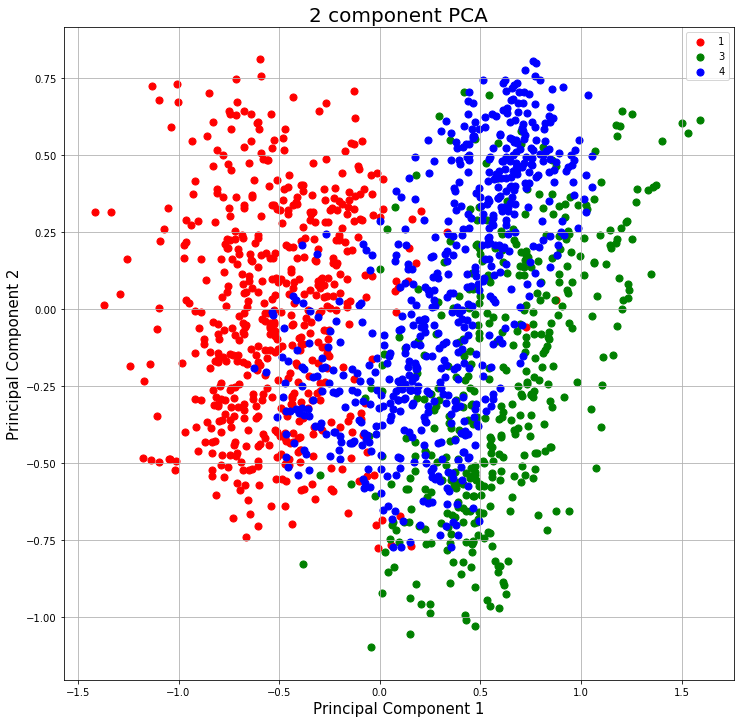

In [15]:
pca = PCA(n_components=2)
pca.fit(allTrainInputs)

# Prints PCA plot (Does only work with a PCA with 2 components)
# Code based on https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60
principalComponents = pca.fit_transform(allTrainInputs)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

finalDf = pd.concat([principalDf, pd.DataFrame(allTrainInputsLabeled)], axis = 1)
# print(finalDf)

fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
# Choose the speakers that you want to visualize in the plot
targets = [1, 3, 4]
colors = 'r', 'g', 'b'
# Uncomment if you want to visualize all speakers
#targets = [1,2,3,4,5,6,7,8,9]
#colors = ['r', 'g', 'b', 'k', 'c', 'm', 'y', 'tab:orange', 'tab:brown']

for target, color in zip(targets,colors):
    indicesToKeep = finalDf[0] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

plt.show()